# Installing the required libraries and Importing them

In [1]:
pip install pygmo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 49.3 MB/s eta 0:00:00


In [2]:
from pygmo import *
import numpy as np

In [3]:
from google.colab import files
files.upload()

Saving drag.py to drag.py
Saving hpc_design_curve.py to hpc_design_curve.py


{'drag.py': b'def factor_nn_nt(nn, nt):\r\n    return -1000.77 + -61.84 *nn + 1196.08 *nt + 35.01 *nn*nn + -5.63 *nn*nt + -366.69 * nt*nt + -3.7 *nn*nn*nn + 0.81 * nn*nn *nt + 0.25 * nn * nt*nt + 37.54 *nt*nt*nt\r\n\r\n\r\ndef factor(r_max, ln, lt):\r\n    return (2.619 - 0.2066 * r_max + 3.3801 * (r_max**2)) * (2.619 - 4.7921 * lt + \\\r\n            3.35582 * (lt**2)) * (2.619 - 5.8352 * ln + 4.1666 * (ln**2)) / (2.169**2)\r\n\r\ndef factor_correction(r_max, ln, lt):\r\n    return 2.7206 * ln - 1.5744 * r_max + 2.9460 * lt + 6.2718 * \\\r\n        (r_max**2) - 1.866 * ln * ln - 2.3126 * lt * lt - 3.4 * ln * lt + 2.1886 * ln * lt * lt - 1.2521\r\n\r\n\r\ndef total_drag(r_max, nn, nt, ln, lt):\r\n    return (factor_nn_nt(nn, nt) * (factor(r_max, ln, lt) +\r\n                                   factor_correction(r_max, ln, lt)))',
 'hpc_design_curve.py': b'import numpy as np\r\nimport numba\r\n\r\n\r\n@numba.njit\r\ndef radius_of_nose(r_max: float, ln: float, nn: float, x_coordinate: flo

In [4]:
import hpc_design_curve as auv
import drag

In [5]:
pip install pymoo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210095 sha256=c430ac44166d3759e141ce5cccb195272d746408c8d32b7d7a78925ea9a50893
  Stored in directory: /root/.cache/pip/wheels/91/a8/bc/5b55a10f763ee2c066ff2d94058d7dd64d570fc45adc027b3d
Successfully built grapheme


# The AUV Class

In [8]:
#This function uses each parameter xi* scaled between 0 and 1 and extrapolates it to its actual value. x = ax* + b
def extract_params(r_max, nn, nt, ln, lt):
    r_max = 0.25 * r_max + 0.25
    nn = 2.5 * nn + 2
    nt = 2.5 * nt + 2
    ln = 0.4 * ln + 0.25
    lt = 0.4 * lt + 0.25

    return [r_max, nn, nt, ln, lt]

In [9]:
class auv_hull:
    #Define Objectives
    def fitness(self, x):
        r_max, nn, nt, ln, lt = extract_params(x[0], x[1], x[2], x[3], x[4])
        total_volume = auv.get_total_volume(r_max, nn, nt, ln, lt)

        d_val = drag.total_drag(r_max, nn, nt, ln, lt) #Minimize
        cylinder_volume = auv.volume_of_midsection(r_max, 3 - ln - lt) #Maximise
        wake_fraction = auv.calc_wake_fraction(r_max, auv.get_block_coefficient(r_max, total_volume), total_volume) #Minimize

        return [d_val, -cylinder_volume, wake_fraction]

    # Return number of objectives
    def get_nobj(self):
        return 3

    # Return bounds of decision variables
    def get_bounds(self):
        return ([0]*5, [1]*5)

    # Return function name
    def get_name(self):
        return "Multi-Objective Particle Swarm Optimisation for AUV Hull"

# The PyGMO Problem

In [10]:
# create UDP
prob = problem(auv_hull())
print(prob)

Problem name: Multi-Objective Particle Swarm Optimisation for AUV Hull
	C++ class name: pybind11::object

	Global dimension:			5
	Integer dimension:			0
	Fitness dimension:			3
	Number of objectives:			3
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0]
	Upper bounds: [1, 1, 1, 1, 1]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none



In [11]:
# create population
pop = population(prob, size= 250)
# select algorithm
algo = algorithm(nspso(gen = 150))
# run optimization
pop = algo.evolve(pop)
# extract results
fits, vectors = pop.get_f(), pop.get_x()
# extract and print non-dominated fronts
ndf, dl, dc, ndr = fast_non_dominated_sorting(fits)

In [12]:
X = pop.get_x()
X[:,0] = 0.25 * (1 + X[:,0])
X[:,1] = 2.5 * X[:,1] + 2
X[:,2] = 2.5 * X[:,2] + 2
X[:,3] = 0.4 * X[:,3] + 0.25
X[:,4] = 0.4 * X[:,4] + 0.25

In [13]:
F = pop.get_f()
F_star = np.empty(shape = (len(ndf[0]), 3))
count = 0
for i in ndf[0]:
    F_star[count] = F[i]
    count = count + 1

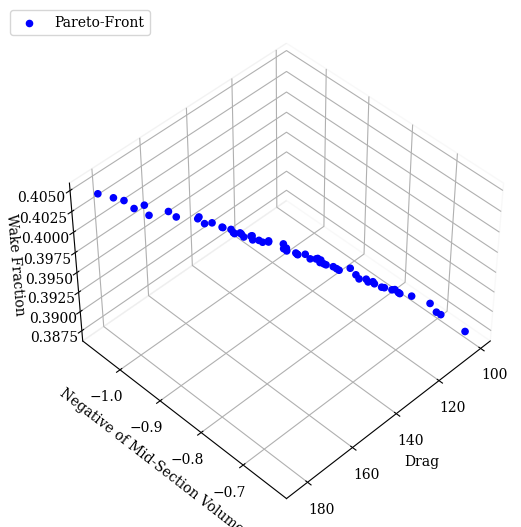

In [15]:
from pymoo.visualization.scatter import Scatter
plot = Scatter(legend=(True, {'loc': "upper left", 'bbox_to_anchor': (-0.1, 1.08, 0, 0)}),
                labels = ['Drag', 'Negative of Mid-Section Volume', 'Wake Fraction'])
plot.add(F_star, color = 'blue', label = 'Pareto-Front')
#plot.add(F, color = 'red', label = 'Population')
plot.show()

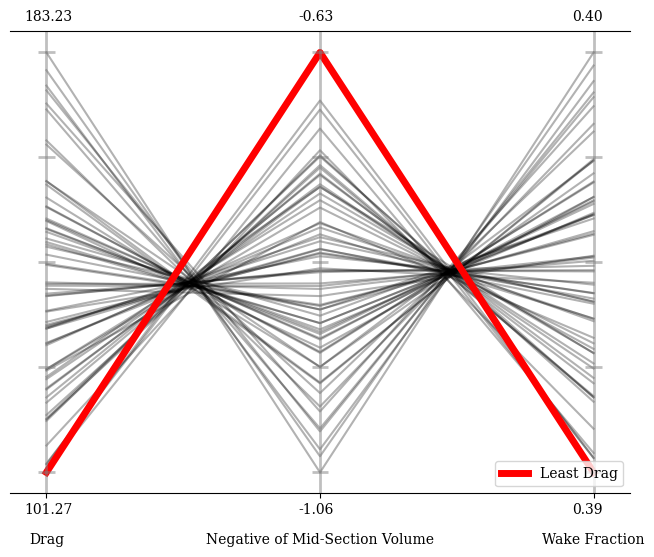

In [42]:
from pymoo.visualization.pcp import PCP
plot = PCP(legend=(True, {'loc': 'lower right'}),
            labels = ['Drag', 'Negative of Mid-Section Volume', 'Wake Fraction'])
plot.set_axis_style(color="grey", alpha=0.5)
plot.add(F_star, color="black", alpha=0.3)
plot.add(F_star[40], linewidth=5, color="red", label = 'Least Drag')
plot.legend
plot.show()

In [ ]:
ax = plot_non_dominated_fronts(pop.get_f(), marker = 'o', comp = [0,1]) 